<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/06_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Генерация изображений (GAN)**

# 1 Постановка задачи

*Подготовьте генеративную сеть, предназначенную для генерации рукописных цифр*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
from keras.datasets import mnist, cifar10                     # Mnist - набор рукописных цифр, cifar10 - изображения объектов 10-ти классов
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply # Базовые слои keras
from keras.layers.advanced_activations import LeakyReLU       # LeakyReLU - функция активации
from keras.layers.convolutional import UpSampling2D, Conv2D   # Сверточные слои keras
from keras.models import Sequential, Model                    # Формат модели keras
from tensorflow.keras.optimizers import Adam                  # Оптимизатор

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Создание генератора

In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
!mkdir images # Создаем каталог 'images'

In [ ]:
def create_generator(): # Функция создания генератора
  generator = Sequential() # Инициализируем модель generator

  generator.add(Dense(256, input_dim=latent_dim)) # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
  generator.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  img = generator(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

  generator = Model(noise, img) # создаем модель generator (входные данные: noise, выходные данные: img)

  return generator # Функция возвращаем generator

In [ ]:
gen = create_generator()
gen.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1493520   
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


In [ ]:
input1 = np.random.random(size=(1, 100))
plt.figure(figsize=(20,15))
plt.imshow(input1, cmap='gray')
plt.axis('off')
plt.show()

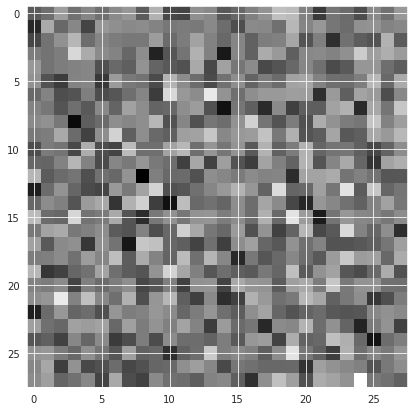

In [ ]:
plt.figure(figsize=(14,7))
predict_gen = gen.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

# 4 Создание дискриминатора

In [ ]:
def create_discriminator(): # Функция создания дискриминатора
  discriminator = Sequential() # Инициализируем модель discriminator

  discriminator.add(Flatten(input_shape=img_shape)) # Создаем слой Flatten (размерность входных данных = (img_rows, img_cols, channels), размерность выходных данных = img_rows * img_cols * channels )
  discriminator.add(Dense(512))  # Добавляем Dense-слой на 512 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  discriminator = Model(img, validity) # Создаем модель discriminator (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  discriminator.trainable = False  # Замораживаем обучение дискриматора

  return discriminator # Функция возвращает discriminator

In [ ]:
dis = create_discriminator()
dis.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


In [ ]:
predict_dis = dis.predict(predict_gen)
print(predict_dis)

[[0.46407276]]


In [ ]:
batch_size = 128 # Размер batch_size

(X_train, _), (_, _) = mnist.load_data() # Загружаем в X_train изображения рукописных цифр из mnist

X_train = X_train / 127.5 - 1. # Трансофрмируем значение в диапазон от -1 до 1
X_train = np.expand_dims(X_train, axis=3) # Добавляем третью размерность для X_train ((28,28) => (28,28,1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def sample_images(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise) # Предиктим картинку с помощью входной переменной gen

  #gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1
  fig, axs = plt.subplots(r, c,figsize=(14,10)) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [ ]:
def train(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения

  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size

  z = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем текущие сгенерированые изображения

  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели

  for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs = X_train[idx] # В переменную imgs записываем значение из X_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений

    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(noise, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100

    # Проверяем на условие вывода информации раз в sample_interval эпох:
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений

  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания:
  plt.figure(figsize=(14,7))
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()


In [ ]:
generator = create_generator()          # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator()  # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 30000)  # Вызываем функцию train с параметрами: generator, discriminator, 30000 (30000 - количество эпох)

In [ ]:
generator.save_weights('drive/My Drive/generator30K.h5')
#generator.load_weights('drive/My Drive/generator30K.h5')

# 5 Результаты

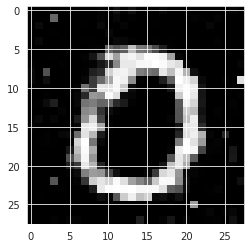

In [ ]:
input1 = np.random.random(size=(1, 100))
predict_gen = generator.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

# 6 Выводы

Разработана и обучена на базе Mnist генеративная нейронная сеть, предназначенная для генерации цифр. Результат обучения нейросети продемонстрирован генерацией цифры "0".